In [1]:
suppressMessages(library(limma))
suppressMessages(library(jsonlite))
suppressMessages(library(progress))
suppressMessages(library(gplots))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(org.Mm.eg.db))
suppressMessages(library(annotate))
suppressMessages(library(mygene))
#suppressMessages(require("biomaRt"))
#suppressMessages(library(gCMAP))
#suppressMessages(library('qusage'))
#suppressMessages(library(TMixClust))


### FUNCTIONS
source("./post_functions/FUN.Run_functional_GSEA.R")
source("./utils/gather.R")
source("./utils/mouse2human.R")
source("./utils/varplot.R")
source("./utils/get_slopes.R")
source("./plot_functions/corplot.R")
source("./plot_functions/FUN.Visualize_GSEA_heatmap.R")
source("./plot_functions/ggcorplot.R")
source("./plot_functions/plot_dynamics.R")
source("./plot_functions/plot_volcano.R")
source("./plot_functions/plot_venn.R")
source('plot_functions/gene_barplot.R')
source('plot_functions/plot_contingency.R')
source('plot_functions/plot_contingency_pair.R')

#OPTIONS
options(warn=-1) #no warnings -1; yes warnings 0
WIDTH = 21.0 #cm

# Panel 1

## Mouse

In [2]:
# show how signature correlates with datasets

### get all needed data
signature_mouse <- read.csv('signatures/reprogramming_mouse_full.csv', row.names=1)
signature_human <- read.csv('signatures/reprogramming_human_full.csv', row.names=1)
signature_humanEtz <- read.csv('signatures/reprogramming_human_full_humanEntrez.csv', row.names=1)
signature_mouse_human <- read.csv('signatures/reprogramming_human_mouse_full.csv', row.names=1)

datasets <- c('GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
              'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
              'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
              'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
              'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
              'GSE127927$7F-Sall4', 'GSE127927$7F', 
              'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1')

# taken from kit standard of 
#https://www.clinisciences.com/en/read/stem-cells-characterization-1087/esc-and-ipsc-characterization-by-1429.html
#and https://www.nature.com/articles/s41598-018-24051-5
pluripotency_mouse <- c('20674', '18999', '71950', '26380', '18613', '81879', '11614', 
                        '22773', '52463', '14562', '22286', '54427', '13436', '17075',
                        '16468', '21420', '50764', '12550', '11647', '636931', '11545',
                        '12349','12443','12444','12447','12575','12578','13435',
                        '13841','14175','14472','16447','16664','16666',
                        '17218','20617','20753','21667','22702','26447',
                        '27205','53972','54427','106344') #mouse Etz

ultradf <- fromJSON("./data/ultradf_v4.json")

#parsing
for (i in names(ultradf)) {
    df <- read.csv(text=ultradf[[i]]$data, row.names=2)[, -1]
    pheno <- read.csv(text=ultradf[[i]]$pheno)
    stopifnot(nrow(pheno)==ncol(df))
    ultradf[[i]]$data <- df
    ultradf[[i]]$pheno <- pheno
}
ultradf <- ultradf[datasets]

tmp_result <- get_slopes(ultradf, stoplist=c(), genelist=c())
datasets_list <- tmp_result[['datasets']]
slopes <- tmp_result[['slopes']]

combined <- c(list("Reprogramming:Mouse"=signature_mouse), datasets_list)

GSE67462$OSKM Pheno: 16 Total: 20479 Passed: 5469 
GSE38509$OSKM Pheno: 18 Total: 20955 Passed: 5255 
GSE38509$OSK Pheno: 6 Total: 20955 Passed: 1050 
GSE116309$OKMS Pheno: 4 Total: 20955 Passed: 0 
GSE116309$OK+9MS Pheno: 4 Total: 20955 Passed: 1253 
GSE46321$C/EBPα+ OSKM Pheno: 18 Total: 22036 Passed: 10185 
GSE114581$OSKM+dox_mef Pheno: 9 Total: 13063 Passed: 3108 
GSE21757$OKMS Pheno: 7 Total: 16480 Passed: 1815 
GSE127927$7F-Esrrb Pheno: 5 Total: 12080 Passed: 541 
GSE127927$7F-Glis1 Pheno: 5 Total: 12080 Passed: 46 
GSE127927$7F-Jdp2 Pheno: 5 Total: 12080 Passed: 19 
GSE127927$7F-Kdm2b Pheno: 5 Total: 12080 Passed: 359 
GSE127927$7F-Mkk6 Pheno: 5 Total: 12080 Passed: 0 
GSE127927$7F-Nanog Pheno: 5 Total: 12080 Passed: 0 
GSE127927$7F-Sall4 Pheno: 5 Total: 12080 Passed: 0 
GSE127927$7F Pheno: 10 Total: 12080 Passed: 3286 
GSE102348$OSKM$Gatad2a-/- Pheno: 9 Total: 11132 Passed: 3346 
GSE102348$OSKM$Mbd3f/- Pheno: 9 Total: 11132 Passed: 2738 
GSE102348$OSKM$WT-1 Pheno: 5 Total: 1113

In [6]:
source("./plot_functions/ggcorplot.R")
source("./plot_functions/plot_dynamics.R")
source("./plot_functions/plot_volcano.R")
source('plot_functions/plot_contingency_pair.R')

gA <- ggheatmap(combined, 
                type='pairwise_top', method='spearman', top=350, pvplot=F,
                label_size=1.2, value_size=0.8, title="Spearman correlation",
                measure="logFC", criterion="FDR",
                orderCol = T, orderRow = T, dendroLineSize = 0.5,
                fontsize = 20,  scaleName = "value",
                distMethod = "euclidean", clustMethod = "complete")

gB <- plot_dynamics(signature_mouse, ultradf, top=5, interval=2)
gC <- plot_volcano(signature_mouse, pluripotency=pluripotency_mouse, fdr_thr=0.001, coef_thr=c(-2.5, 2.5),)
gD <- plot_contingency_pair(signature_mouse, signature_human, suf1='Mouse', suf2='Human')

uprow <- cowplot::plot_grid(gA, gC, ncol=1, labels = c("B", "D"), label_size = 32, rel_heights = c(3, 1.5))
dwrow <- cowplot::plot_grid(gB, gD, ncol=1, labels = c("C", "E"), label_size = 32, rel_heights = c(3, 1.5))
P <- cowplot::plot_grid(uprow, dwrow, nrow=1, label_size = 32, rel_widths = c(3, 1.8))

ggsave('figs/panel1.pdf', P, width=WIDTH, height=17.0, units = "cm", dpi=300, scale=2.5)

Using rowname as id variables

Using rowname as id variables



In [68]:
#plot_dynamics(signature_mouse, ultradf, top=5, interval=2, selected_genes=c('Ccnd1', "Ccnd2", "Cdkn1a"))

## Human

In [67]:
datasets <- c('GSE89455$OSKM$HDF', 'GSE89455$OSKM$HAdMSC', 'GSE89455$OSKM$HA', 
             'GSE89455$OSKM$HBEC','GSE89455$OSKM$HPrEC','GSE50206$OSKM$HDF',
             'GSE50206$OSKM$ASC','GSE50206$OSKM$HA','GSE50206$OSKM$NHBE',
             'GSE50206$OSKM$PrEC','GSE54848$OSKM$HDF')

#human Etz
plh <- toupper(as.character(read.csv('subdata/pluripotency_genes_human.csv')$Symbol))
pluripotency_human <- rownames(signature_humanEtz[signature_humanEtz$symbol %in% plh,])

ultradf <- fromJSON("./data/ultradf_human_v3.json") #ultradf_human is always with human EntrezID

#parsing
for (i in names(ultradf)) {
    df <- read.csv(text=ultradf[[i]]$data, row.names=2)[, -1]
    pheno <- read.csv(text=ultradf[[i]]$pheno)
    stopifnot(nrow(pheno)==ncol(df))
    ultradf[[i]]$data <- df
    ultradf[[i]]$pheno <- pheno
}
ultradf <- ultradf[datasets]

tmp_result <- get_slopes(ultradf, stoplist=c(), genelist=c())
datasets_list <- tmp_result[['datasets']]
slopes <- tmp_result[['slopes']]

combined <- c(list("Reprogramming:Human"=signature_humanEtz), datasets_list)

GSE89455$OSKM$HDF Pheno: 21 Total: 16983 Passed: 7188 
GSE89455$OSKM$HAdMSC Pheno: 21 Total: 16983 Passed: 6835 
GSE89455$OSKM$HA Pheno: 21 Total: 16983 Passed: 7375 
GSE89455$OSKM$HBEC Pheno: 21 Total: 16983 Passed: 6337 
GSE89455$OSKM$HPrEC Pheno: 21 Total: 16983 Passed: 7314 
GSE50206$OSKM$HDF Pheno: 30 Total: 21754 Passed: 12712 
GSE50206$OSKM$ASC Pheno: 16 Total: 21754 Passed: 9933 
GSE50206$OSKM$HA Pheno: 28 Total: 21754 Passed: 9117 
GSE50206$OSKM$NHBE Pheno: 19 Total: 21754 Passed: 9667 
GSE50206$OSKM$PrEC Pheno: 15 Total: 21754 Passed: 4741 
GSE54848$OSKM$HDF Pheno: 33 Total: 21755 Passed: 13051 


In [68]:
gA <- ggheatmap(combined, 
                type='pairwise_top', method='spearman', top=350, pvplot=F,
                label_size=1.2, value_size=0.8, title="Spearman correlation",
                measure="logFC", criterion="FDR",
                orderCol = T, orderRow = T, dendroLineSize = 0.5,
                fontsize = 20,  scaleName = "value",
                distMethod = "euclidean", clustMethod = "complete")
gB <- plot_dynamics(signature_humanEtz, ultradf, top=5, interval=2)

gC <- plot_volcano(signature_humanEtz, pluripotency=pluripotency_human, fdr_thr=0.01, coef_thr=c(-4.0, 4.0), xlim=c(-7,7))
gD <- plot_volcano(signature_mouse_human, pluripotency_mouse, fdr_thr=0.0001, coef_thr=c(-3.0, 3.0))

uprow <- cowplot::plot_grid(gA, gB, nrow=1, labels = c("A", "B"), label_size = 32, rel_widths = c(3, 1.8))
dwrow <- cowplot::plot_grid(gC, gD, nrow=1, labels = c("C", "D"), label_size = 32, rel_widths = c(3, 3))
P <- cowplot::plot_grid(uprow, dwrow, ncol=1, label_size = 32, rel_heights = c(3, 1.5))

ggsave('figs/panelS1.pdf', P, width=WIDTH, height=17.0, units = "cm", dpi=300, scale=2.5)

Using rowname as id variables

Using rowname as id variables



# Panel 2

In [3]:
# show how signature correlates with datasets

### get all needed data
signature_mouse <- read.csv('signatures/reprogramming_mouse_full.csv', row.names=1)
signature_human <- read.csv('signatures/reprogramming_human_full.csv', row.names=1)
signature_humanEtz <- read.csv('signatures/reprogramming_human_full_humanEntrez.csv', row.names=1)
signature_mouse_human <- read.csv('signatures/reprogramming_human_mouse_full.csv', row.names=1)

combined_full_rep <- readRDS('signatures/combined_full_rep.rds')

gsea <-readRDS("gsea_results/fgsea_results_All.rds")
#make all pathways as indices
for (name in names(gsea)){
    gsea[[name]] <- as.data.frame(gsea[[name]])
    rownames(gsea[[name]]) <- gsea[[name]]$pathway
}

In [14]:
source('plot_functions/plot_hallmark.R')
source("./plot_functions/ggcorplot_hallmark.R")
source('plot_functions/gene_barplot.R')
source('plot_functions/plot_contingency.R')

tmpplot <- ggheatmap_hallmark(gsea, gsea,
                type='pairwise_top', method='spearman', top=500, pvplot=F,
                label_size=1.2, value_size=0.8, title="Spearman correlation",
                measure="NES", criterion="padj",
                orderCol = T, orderRow = T, dendroLineSize = 0.5,
                scaleName = "value",
                distMethod = "euclidean", clustMethod = "complete", 
                scale_name="NES \nSpearman \ncorrelation ")

gA <- tmpplot[['A']]
gB <- tmpplot[['B']]
left <- cowplot::plot_grid(gA, gB, labels=c("A", "B"), label_size = 32, ncol=1, align='v', 
                           rel_heights = c(2, 3))

gene_interest <- c('Igf1', 'Rela', 'Rragc', 'Mrpl11', 'Trappc6a', 'Uqcrq')
#gene_interest <- c('Mmp9', 'Gadd45a', 'Itpr3', 'Bmp2', 'Igfbp3', 'Sesn2', 'Ptges', 'Fos')
gC <- gene_barplot(combined_full_rep, gene_interest)

gD1 <- plot_contingency(combined_full_rep, 'Interventions', lims=c())
gD2 <- plot_contingency(combined_full_rep, 'Aging', lims=c(-37, 37), textcol='black')
gD <- cowplot::plot_grid(gD1, gD2, ncol=2, nrow=1, rel_heights = c(2, 2))

right <- cowplot::plot_grid(gC, gD, labels=c('C', 'D'), ncol=1, nrow=2, 
                            label_size = 32, rel_heights = c(4.65, 1.35))

P2 <- cowplot::plot_grid(left, right, ncol=2, nrow=1, 
                            label_size = 32, rel_widths = c(2.5, 2))

ggsave('figs/panel2.pdf', P2, width=WIDTH, height=19.0, units = "cm", dpi=300, scale=2.5)

Using rowname as id variables

Using rowname as id variables



In [17]:
#Signature meta-slopes correlation
source("./plot_functions/ggcorplot.R")
gA <- ggheatmap(combined_full_rep, 
                type='pairwise_top', method='spearman', top=350, pvplot=F,
                label_size=1.2, value_size=0.8, title="Spearman correlation",
                measure="logFC", criterion="FDR",
                orderCol = T, orderRow = T, dendroLineSize = 0.5,
                fontsize = 20,  scaleName = "value",
                distMethod = "euclidean", clustMethod = "complete")

ggsave('figs/signature_correlations.pdf', gA, width=WIDTH, height=19, units = "cm", dpi=300, scale=1.5)

Using rowname as id variables

Using rowname as id variables



In [105]:
# library(tools)
# EMT <- as.character(read.csv('tmp/EMT_geneset.txt', skip = 2, header=F)$V1)
# EMT <- toTitleCase(tolower(EMT))

# intersect(EMT, as.character(signature_mouse[pluripotency_mouse,]$symbol))

# temp <- combined_full_rep

# rm <- temp[['Reprogramming:Mouse']]
# rh <- temp[['Reprogramming:Human']]
# ra <- temp[['Reprogramming:All']]

# temp[['Reprogramming:Mouse']] <- rm[!rm$symbol %in% EMT,]
# temp[['Reprogramming:Human']] <- rh[!rh$symbol %in% EMT,]
# temp[['Reprogramming:All']] <- ra[!ra$symbol %in% EMT,]

# options(repr.plot.width = 10, repr.plot.height = 5)
# gC1 <- plot_contingency(temp, 'Interventions', lims=c())
# gC2 <- plot_contingency(temp, 'Aging', lims=c(-37, 37), textcol='black')
# cowplot::plot_grid(gC1, gC2, labels=c('C', ''), ncol=2, nrow=1, 
#                             label_size = 32, rel_heights = c(2, 2))

# Panel 3

In [8]:
clockm <- read.csv('clocks/Mouse_clock_output.csv', row.names=1)
#clockh <- read.csv('clocks/Human_clock_output.csv', row.names=1)
clockh <- read.csv('clocks/final/Human_predictions_clock.csv', row.names=1)
gef <- read.csv('clocks/gene_effects.csv')
grefm <- read.csv('clocks/mouse_group_effects.csv')
grefh <- read.csv('clocks/human_group_effects.csv')
enr <- read.csv('clocks/rej_genes_enrich.csv', row.names=1)
traj <- read.csv('clocks/trajectories.csv')

#combine group knockout effects
grefm$species <- 'Mouse'
#grefh$species <- 'Human'
gref <- grefm #rbind(grefm, grefh)

In [11]:
#corplot + hallmark
source('plot_functions/rej_genes_enrich.R')
source('plot_functions/plot_all_clocks.R')
source('plot_functions/plot_group_clocks.R')
source('plot_functions/plot_gene_effects.R')
source('plot_functions/plot_group_effects.R')
source('plot_functions/plot_trajectories.R')

gA <- plot_trajectories(traj)

gBCD <- plot_group_clocks(clockm, clockh)

top <- cowplot::plot_grid(gBCD[["B"]], gBCD[['C']], gBCD[['D']], gA, 
                        labels=c("A", "B", "C", 'D'), label_size = 32, ncol=2, align='hv', 
                        rel_heights = c(3, 3), rel_widths = c(3, 3))
gE <- rej_genes_enrich(enr)
gF <- plot_gene_effects(gef, 10)
gG <- plot_group_effects(gref)

bottom <-cowplot::plot_grid(gE, gF, gG, labels=c("E", "F", "G"), label_size = 32, ncol=3, rel_widths = c(1., 2.5, 1.1))
P3 <- cowplot::plot_grid(top, bottom, label_size = 32, nrow=2, rel_heights = c(3, 1))

ggsave('figs/panel3.pdf', P3, units = "cm", width=WIDTH, height=21.0, dpi=300, scale=2.5)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`summarise()` ungrouping output (override with `.groups` argument)



In [37]:
source('plot_functions/plot_all_clocks.R')
PS3 <- plot_all_clocks(clockm, clockh)
ggsave('figs/panelS3.pdf', PS3, units = "cm", width=WIDTH, height=24., dpi=300, scale=2.5)

In [62]:
# source('plot_functions/plot_hallmark.R')
# lis <- plot_hallmark(gsea, F, return_table=TRUE)
#df[df$Function == 'Bile acid metabolism',]

In [102]:
#gmean <- function(x) exp(mean(log(x)))
# print('aging')
# lis[['sla']][c('HALLMARK_INFLAMMATORY_RESPONSE', 
#                 'HALLMARK_IL6_JAK_STAT3_SIGNALING',
#                 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'),]

# print('reprog')
# lis[['slr']][c('HALLMARK_INFLAMMATORY_RESPONSE', 
#                 'HALLMARK_IL6_JAK_STAT3_SIGNALING',
#                 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'),]

# #exp(mean(log(c(0.0063, 0.3))))

# print('reprog')
# lis[['slr']][c('HALLMARK_APOPTOSIS', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA'),]
# print('interv')
# lis[['sli']][c('HALLMARK_APOPTOSIS', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA'),]
# print('age')
# lis[['sla']][c('HALLMARK_APOPTOSIS', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA'),]

In [6]:
# plot_gene_effects <- function(gef, top=10, thr=0.05, fontsize=18){
# agef <- aggregate(.~symbol, gef, FUN="mean")[,c("symbol", "knockout_effect", "FDR")]
# gef$star <- as.character(gef$star)
# agef['star']<- aggregate(.~symbol, gef, FUN=function(x){x[[1]]})[,c("symbol", "star")]$star
# agef <- agef[agef$FDR < 0.05,]

# selected_agef <- agef[order(agef$knockout_effect, decreasing=T),][1:top,]
# selected <- selected_agef$symbol
# selected_mean <- selected_agef$knockout_effect
# selected_star <- selected_agef$star
# sgef <- gef[gef$symbol %in% selected,]
# sgef$symbol <- factor(sgef$symbol, levels=selected)

# p <- ggplot(data=sgef, aes(x=symbol, y=knockout_effect)) +
#         geom_boxplot(aes(fill=symbol), alpha = 0.8, outlier.shape = NA, lwd=1.2) + 
#         #scale_fill_viridis(discrete = TRUE, alpha=0.6, option="H")+
#         #scale_fill_manual(values = cols)+
#         scale_fill_brewer(palette='Purples')+
#         geom_hline(yintercept=0, linetype="dashed", color = "black", size=0.4, alpha=0.8)+
#         geom_point(aes(fill='black'), alpha=0.4, size = 1., position = position_jitterdodge(0.1))+
#         geom_text(data=data.frame(), aes(label=selected_star, x=selected, y=selected_mean), 
#         vjust=-4.0, fontface='bold', size=7, color='black')+
#         theme(  axis.text=element_text(size=fontsize),
#         axis.title=element_text(size=fontsize, face="bold"),
#         panel.background = element_rect(fill='white', colour='black', size=1.5, linetype='solid'),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         legend.position = "none",
#         plot.margin = unit(c(1,1,0,0.5), "cm")) +
#         labs(x = "", y = "Rejuvenation effect decreasing, %")
#         return(p)
# }

# Panel 5

In [2]:
#panel with cmap analysis of interventions
drugHuman <- read.csv('drugs/human_clocks_cmap_results.csv')
selected_drugs <- read.csv('drugs/selected_drugs_NES.csv')
drugHuman$coincide <- ifelse(drugHuman$Avg > 0, 'Positive', 'Negative')

In [5]:
options(repr.plot.width = 16, repr.plot.height = 18)

source('plot_functions/plot_drug_effects.R')
source('plot_functions/plot_drugs_NES.R')
top <- plot_drug_effects(drugHuman)
bottom <- plot_drugs_NES(selected_drugs, drugHuman)

P5 <- cowplot::plot_grid(top, bottom, label_size = 32, labels=c('B', 'C'), 
                         nrow=2, rel_heights = c(2.5, 1))

ggsave('figs/panel5.pdf', P5, units = "cm", width=WIDTH, height=17.0, dpi=300, scale=2.0)

In [ ]:
drugMouse <- read.csv('drugs/human_clocks_cmap_results.csv')

# All correlations


In [4]:
# Give the input file name to the function.
ultradf <- fromJSON("./data/ultradf_v4.json")

#parsing mouse
for (i in names(ultradf)) {
    df <- read.csv(text=ultradf[[i]]$data, row.names=2)[, -1]
    pheno <- read.csv(text=ultradf[[i]]$pheno)
    stopifnot(nrow(pheno)==ncol(df))
    ultradf[[i]]$data <- df
    ultradf[[i]]$pheno <- pheno
}

ultrahuman <- fromJSON("./data/ultradf_human_v3.json")

#parsing human
for (i in names(ultrahuman)) {
    df <- read.csv(text=ultrahuman[[i]]$data, row.names=2)[, -1]
    pheno <- read.csv(text=ultrahuman[[i]]$pheno)
    stopifnot(nrow(pheno)==ncol(df))
    ultrahuman[[i]]$data <- df
    ultrahuman[[i]]$pheno <- pheno
}

# convert human etz to mouse etz
one2one <- read.csv('subdata/human2mouse_entrez.csv')
#convert human to mouse in all human datasets
for (i in 1:length(ultrahuman)){
    tmp <- ultrahuman[[i]]$data[as.character(one2one$human),]
    rownames(tmp) <- as.character(one2one$mouse)
    ultrahuman[[i]]$data <- tmp
}

#merge mouse and human
ultradf <- c(ultradf, ultrahuman)

tmp_result <- get_slopes(ultradf, stoplist=c(), genelist=c())
datasets_list <- tmp_result[['datasets']]

GSE67462$OSKM Pheno: 16 Total: 20479 Passed: 5469 
GSE38509$OSKM Pheno: 18 Total: 20955 Passed: 5255 
GSE38509$OSK Pheno: 6 Total: 20955 Passed: 1050 
GSE38509$GFP Pheno: 11 Total: 20955 Passed: 5062 
GSE116309$OKMS Pheno: 4 Total: 20955 Passed: 0 
GSE116309$OK+9MS Pheno: 4 Total: 20955 Passed: 1253 
GSE46321$C/EBPα+ OSKM Pheno: 18 Total: 22036 Passed: 10185 
GSE46321$C/EBPα- OSKM Pheno: 18 Total: 22036 Passed: 1878 
GSE10871$OSKM Pheno: 8 Total: 20887 Passed: 64 
GSE21757$OKMS Pheno: 7 Total: 16480 Passed: 1815 
GSE103979$Oct4+SK Pheno: 10 Total: 12368 Passed: 5120 
GSE103979$Oct6+SK Pheno: 10 Total: 12368 Passed: 3182 
GSE103979$Oct4+defSox+K Pheno: 10 Total: 12368 Passed: 3681 
GSE103979$GFP Pheno: 10 Total: 12368 Passed: 3369 
GSE114581$OSKM+dox_mef Pheno: 9 Total: 13063 Passed: 3108 
GSE114581$OSKM-dox_mef Pheno: 10 Total: 13063 Passed: 3713 
GSE127927$7F-Esrrb Pheno: 5 Total: 12080 Passed: 541 
GSE127927$7F-Glis1 Pheno: 5 Total: 12080 Passed: 46 
GSE127927$7F-Jdp2 Pheno: 5 Total:

In [6]:
gA <- ggheatmap(datasets_list, 
                type='pairwise_top', method='spearman', top=350, pvplot=F,
                label_size=1.2, value_size=0.8, title="Spearman correlation",
                measure="logFC", criterion="FDR",
                orderCol = T, orderRow = T, dendroLineSize = 0.5,
                fontsize = 20,  scaleName = "value",
                distMethod = "euclidean", clustMethod = "complete")

ggsave('figs/all_correlations.pdf', gA, width=WIDTH, height=19, units = "cm", dpi=300, scale=2.5)

Using rowname as id variables

Using rowname as id variables



# Specific genes exploration

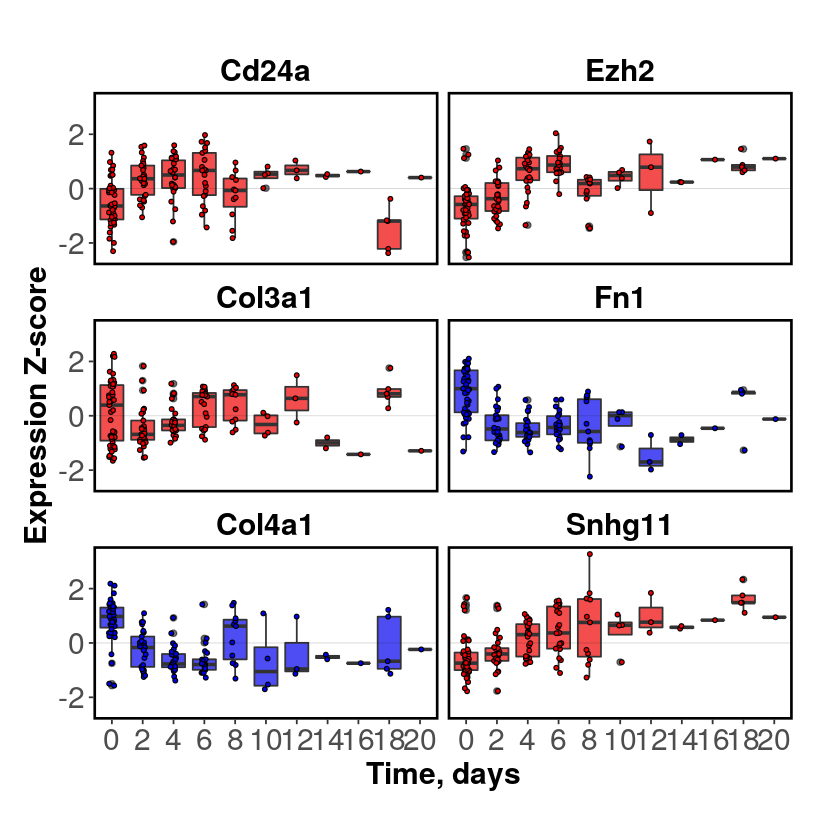

In [22]:
plot_dynamics(signature_mouse, ultradf, top=5, interval=2, 
            selected_genes=c('Col3a1', "Ezh2", "Cd24a", "Col4a1", 'Fn1', 'Snhg11'))

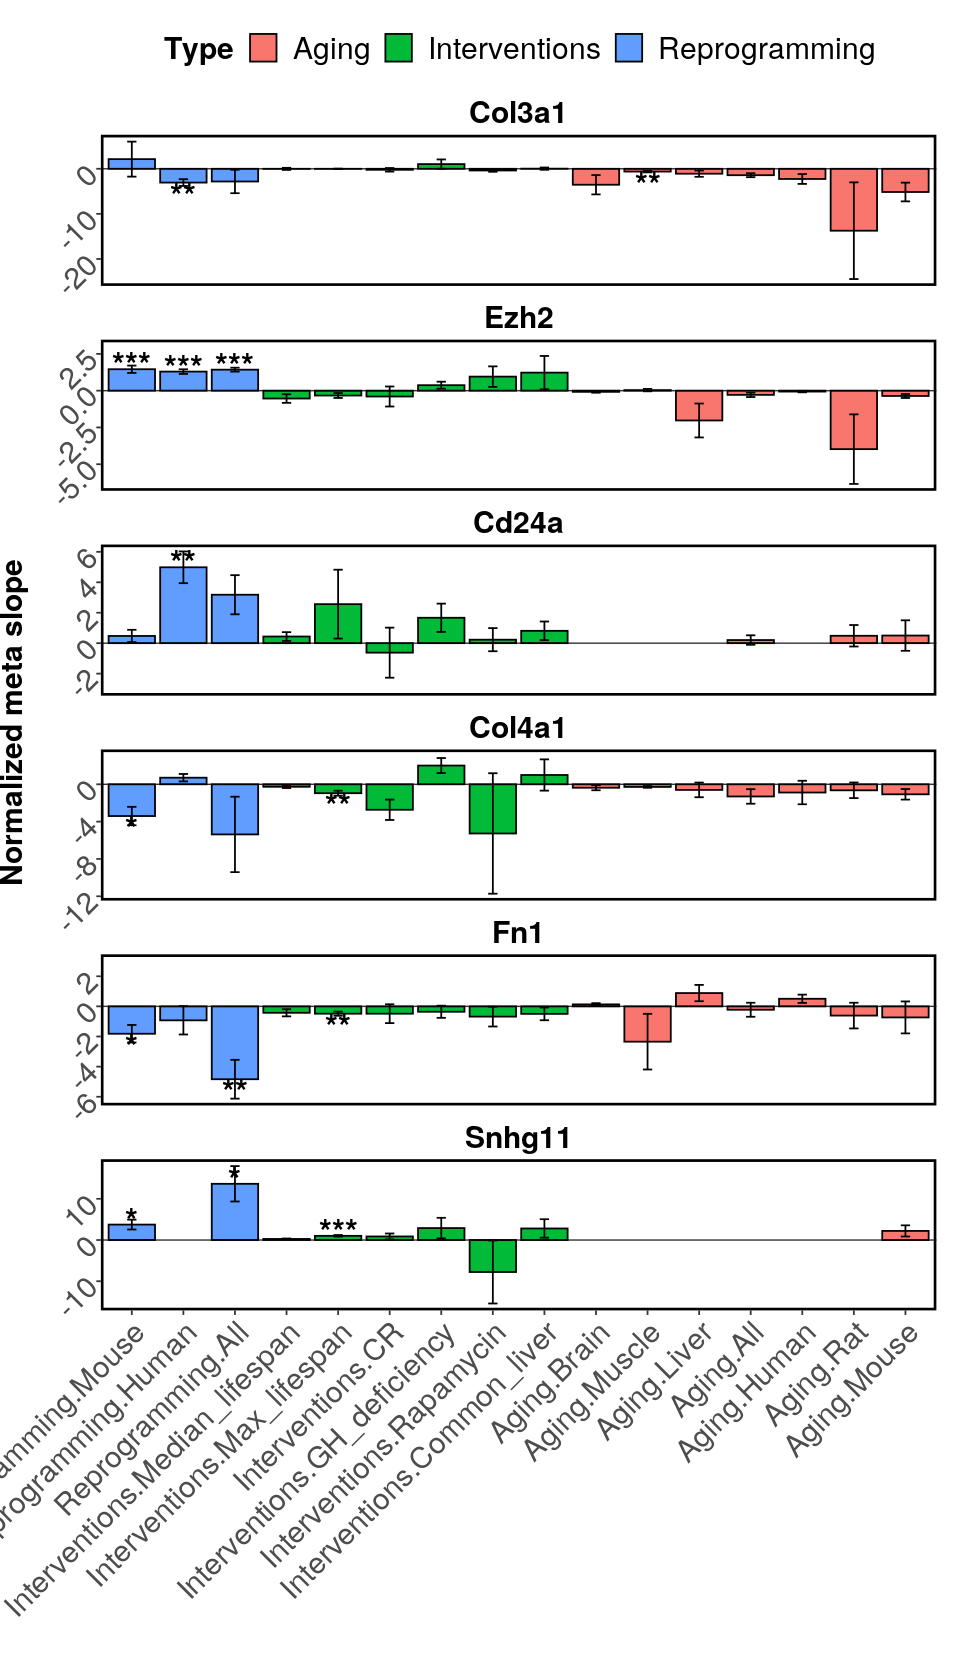

In [26]:
source('plot_functions/gene_barplot.R')

gene_interest <- c('Col3a1', "Ezh2", "Cd24a", "Col4a1", 'Fn1', 'Snhg11')
#gene_interest <- c('Mmp9', 'Gadd45a', 'Itpr3', 'Bmp2', 'Igfbp3', 'Sesn2', 'Ptges', 'Fos')
options(repr.plot.width = 8, repr.plot.height = 14)

gene_barplot(combined_full_rep, gene_interest)

# Garbage collector

In [30]:
# SL <- list()
# cols <- c('NES', 'pval', 'padj')
# types <- c(rep('Reprogramming',3), rep('Interventions',6), rep('Aging', 7))

# for (col in cols){
#     SL[[col]] <- data.frame(row.names=rownames(gsea[[1]]))
#     for (name in names(gsea)){
#             tmp <- gsea[[name]][col]
#             colnames(tmp) <- c(name)
#             SL[[col]] <- transform(merge(SL[[col]], tmp, 
#                                                 by=0, sort=F,), 
#                                                 row.names=Row.names, Row.names=NULL)
#     }
# }

# tmpdf <- gsea[[1]]

In [73]:
#asub <- SL[['pval']][, types=='Aging']
#as.vector(apply(asub, 1, gmean)

In [110]:
# # top <- 5
# gmean <- function(x) exp(mean(log(x)))
# # gm = as.data.frame(list('gmean'=apply(SL[['P.Value']], 1, gmean )))
# # gm <- rownames(gm[order(gm$gmean),, drop=FALSE])[1:top]

# #gmean
# asub <- SL[['padj']][, types=='Aging']
# GM <- as.vector(apply(asub, 1, gmean))
# asub <- (GM < 0.05)

# isub <- SL[['padj']][, types=='Interventions']
# GM <- as.vector(apply(isub, 1, gmean))
# isub <- (GM < 0.05)

# rsub <- SL[['padj']][, types=='Reprogramming']
# GM <- as.vector(apply(rsub, 1, gmean))
# rsub <- (GM < 0.05)

# #mean
# amub <- SL[['NES']][, types=='Aging']
# GM <- as.vector(apply(amub, 1, mean))
# amub <- (GM > 0.)

# imub <- SL[['NES']][, types=='Interventions']
# GM <- as.vector(apply(imub, 1, mean))
# imub <- (GM < 0.)

# rmub <- SL[['NES']][, types=='Reprogramming']
# GM <- as.vector(apply(rmub, 1, mean))
# rmub <- (GM < 0.)

# direction_cond <- asub & rsub & amub & imub & rmub


# cond <- SL[['padj']][direction_cond,]
# cond_filt <- cond[order(cond$Reprogramming.Mouse),]
# accepted <- rownames(cond_filt)
# length(accepted)

[1] 69

In [113]:
# #func_interest <- accepted[1:6]
# func_interest <- c('GOBP_ATP_METABOLIC_PROCESS', 
#                    'KEGG_RIBOSOME',
#                    'REACTOME_MITOCHONDRIAL_TRANSLATION')

In [43]:
# melter <- data.frame()
# for (f in func_interest){
#         #func for mapping stars
#         plab <- function(p )ifelse(p<0.001,'***', ifelse(p<0.01,'**', ifelse(p<0.05,'*',''))) 

#         #rescale columns
#         tmpLogFC <- SL[['NES']] #/ apply(SL[['NES']], 2, sd)

#         mel <- t(tmpLogFC[f,])
#         mel <- transform(merge(mel,  t(SL[['pval']][f,]), by=0, sort=F), 
#                                         row.names=Row.names, Row.names=NULL)
#         mel <- merge(mel,  t(SL[['padj']][f,]), by=0, sort=F)
#         mel$Function <- rep(f, nrow(mel))
#         colnames(mel) <- c('Signature', 'NES', 'Pval', 'Padj', 'Function')
#         mel$Type <- types
#         mel$Signature <- factor(as.character(mel$Signature), levels=unique(as.character(mel$Signature)))
#         mel$Star <- plab(mel$Padj)
#         mel$Vjust <- if_else(mel$NES > 0, 0.2, 1.1)
#         # mel$Symbol <- rep(sym, nrow(mel))
#         melter <- rbind(melter, mel)
# }

# #plot
# options(repr.plot.width = 10, repr.plot.height = 16)
# g <- ggplot(melter, aes(x=Signature, y=NES, fill=Type))+ 
#         geom_bar(stat="identity") +
#         facet_wrap(~Function, ncol=1, scales = "free_y", dir="v") + 
#         geom_text(aes(label=Star, vjust=melter$Vjust, hjust=0.5), fontface='bold', size=7)+
#         #geom_errorbar(aes(ymin=Coef-SE, ymax=Coef+SE), width=0.18) + 
#         theme(axis.text=element_text(size=14, angle=45, hjust=1),
#                 strip.background = element_blank(),
#                 strip.placement = 'inside',
#                 strip.text = element_text(colour = 'black', size=16, face="bold", hjust = 0.5),     
#                 axis.title=element_text(size=18, face="bold"), 
#                 plot.title=element_text(size = 20, face = "bold"),
#                 legend.title=element_text(size=16, face = "bold"),
#                 legend.text=element_text(size=14),
#                 legend.position="top",
#                 panel.background = element_rect(fill='white', colour='black', size=1.1, linetype='solid'),
#                 panel.grid.major = element_blank(),
#                 panel.grid.minor = element_blank(),
#                 plot.margin = unit(c(0.5,0.5,0.5,0.), "cm")) +
#                 labs(x = "", y = "NES")+
#                 expand_limits(y=c(-3, 3))
# g


In [93]:
#function to calculate linear model p-values for tAge prediction dynamics
fill_tAge_pvalues <- function(dataset_predictions,dataset_values=paste0(dataset_predictions$GEO,".",dataset_predictions$Treatment)){
  dataset_predictions$Dataset <- dataset_values
  output_table <- data.frame(Dataset=names(table(dataset_predictions$Dataset)))
  rownames(output_table) <- output_table$Dataset
  tAge_columns <- colnames(dataset_predictions)[grepl("tAge",colnames(dataset_predictions))]
  for (temp_model in tAge_columns){
    for (temp_dataset in unique(dataset_predictions$Dataset)){
      temp_data <- dataset_predictions[dataset_predictions$Dataset==temp_dataset,]
      temp_test <- summary(lm(temp_data[,temp_model]~temp_data$Time))
      temp_pvalue <- temp_test$coefficients[2,4]
      output_table[temp_dataset,temp_model] <- temp_pvalue
    }
  }
  output_table <- output_table
  return(output_table)
}


#function to visualize tAge dynamics plots
visualize_plots <- function(dataset_predictions,model,units="relative units",
                            separate_by_geo=T,
                            scaling=F,single_plot=T,add_mean_plot=T,
                            moving_average=F,step=1,point_size=5,
                            line_width=0.8,label_size=12,axis_size=12,
                            point_alpha=1,legend_size=16,
                            title_size=12,
                            legend_within=F,folder=getwd(),
                            file_name=F){
  setwd(folder)
  library(ggplot2)
  data_for_ggplot <- data.frame(GEO=dataset_predictions$GEO,
                                Treatment=dataset_predictions$Treatment,
                                tAge=dataset_predictions[,model],
                                Time=dataset_predictions$Time)
  data_for_ggplot$Dataset <- paste0(data_for_ggplot$GEO,".",data_for_ggplot$Treatment)
  if (scaling==T){
    for (temp_dataset in levels(factor(data_for_ggplot$Dataset))){
      data_for_ggplot[data_for_ggplot$Dataset==temp_dataset,]$tAge <- scale(data_for_ggplot[data_for_ggplot$Dataset==temp_dataset,]$tAge,center = F,scale = T)
    }
  }
  print(data_for_ggplot[data_for_ggplot$Time==0,]$tAge)
  pvalues_table <- fill_tAge_pvalues(data_for_ggplot)
  pvalues_table$tAge <- p.adjust(pvalues_table$tAge,"BH")
  pvalues_table$Label <- ifelse(pvalues_table$tAge >=0.05,"",
                                ifelse(pvalues_table$tAge>=0.01,"*",
                                       ifelse(pvalues_table$tAge>=0.001,"**","***")))
  y_label <- paste0("tAge, ",units)
  
  
  if (single_plot==F){
    for (temp_GEO in levels(factor(data_for_ggplot$GEO))){
      temp_data <- data_for_ggplot[data_for_ggplot$GEO==temp_GEO,]
      temp_data$Dataset <- paste0(temp_data$GEO,".",temp_data$Treatment)
      temp_data$Treatment <- paste0(temp_data$Treatment," ", pvalues_table[temp_data$Dataset,]$Label)
      t <- ggplot(temp_data,aes(x=Time,y=tAge))+
        labs(title=temp_GEO,x="Days of reprogramming",y=y_label)+
        theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
        geom_smooth(aes(color=Treatment),formula = y~x,method = "lm",se = F,lwd=line_width,alpha=0.5)+
        geom_point(aes(fill=Treatment),colour="black",size=point_size,shape=21,alpha=point_alpha)+
        theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
              axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
              axis.text.y = element_text(size=12,color="black"),
              axis.title=element_text(size=18),
              legend.title=element_text(size=legend_size+2,color="black"),
              legend.text=element_text(size=legend_size,color="black"),
              legend.key.size = unit(1.5, 'lines'),
              panel.grid = element_blank())+
        theme(plot.title = element_text(size=26))
      
      pdf(paste0(temp_GEO,".",model, ".pdf"),
          paper = "a4r",width = 14)
      print(t)
      dev.off()
      print(t)
      
    }
    
  }else{
    if (separate_by_geo==T){
      if (class(file_name)=="logical"){
        file_name <- paste0("Aggregated",".",model, ".pdf")
      }

      t <- ggplot(data_for_ggplot,aes(x=Time,y=tAge))+
        facet_wrap(~GEO,scales="free")+
        labs(x="Days of reprogramming",y=y_label)+
        theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
        geom_smooth(aes(color=Treatment),formula = y~x,method = "lm",se = F,lwd=line_width,alpha=0.5)+
        geom_point(aes(fill=Treatment),colour="black",size=point_size,shape=21,alpha=point_alpha)+
        theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
              axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
              axis.text.y = element_text(size=12,color="black"),
              axis.title=element_text(size=18),
              legend.title=element_text(size=legend_size+2,color="black"),
              legend.text=element_text(size=legend_size,color="black"),
              legend.key.size = unit(1.5, 'lines'),
              panel.grid = element_blank(),
              strip.background =element_rect(fill="white"),
              strip.text = element_text(size=label_size,face="bold"))
      pdf(file_name,
          paper = "a4r",width = 24)
      print(t)
      dev.off()
      
      print(t)
    }else{
      if (class(file_name)=="logical"){
        file_name <- ifelse(scaling==F,paste0("Combined",".",model, ".pdf"),
                            paste0("Combined.Scaled.",model, ".pdf"))
      }
      pvalues_table <- fill_tAge_pvalues(data_for_ggplot,data_for_ggplot$Treatment)
      pvalues_table$tAge <- p.adjust(pvalues_table$tAge,"BH")
      pvalues_table$Label <- ifelse(pvalues_table$tAge >=0.05,"",
                                    ifelse(pvalues_table$tAge>=0.01,"*",
                                           ifelse(pvalues_table$tAge>=0.001,"**","***")))
      data_for_ggplot$Treatment <- paste0(data_for_ggplot$Treatment," ", pvalues_table[data_for_ggplot$Treatment,]$Label)
      
      if (length(unique(data_for_ggplot$Treatment))>1){
        t <- ggplot(data_for_ggplot,aes(x=Time,y=tAge))+
          labs(x="Days of reprogramming",y=y_label)+
          theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
          geom_smooth(aes(color=Treatment),formula = y~x,method = "lm",se = F,lwd=line_width,alpha=0.5)+
          geom_point(aes(fill=Treatment),colour="black",size=point_size,shape=21,alpha=point_alpha)+
          theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
                axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
                axis.text.y = element_text(size=12,color="black"),
                axis.title=element_text(size=18),
                legend.title=element_text(size=legend_size+2,color="black"),
                legend.text=element_text(size=legend_size,color="black"),
                legend.key.size = unit(1.5, 'lines'),
                panel.grid = element_blank(),
                strip.background =element_rect(fill="white"),
                strip.text = element_text(size=label_size,face="bold"))
      }else{
        t <- ggplot(data_for_ggplot,aes(x=Time,y=tAge))+
          labs(x="Days of reprogramming",y=y_label)+
          theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
          geom_smooth(color="black",formula = y~x,method = "loess",se = F,lwd=line_width,alpha=0.5)+
          geom_point(aes(fill=GEO),colour="black",size=point_size,shape=21,alpha=point_alpha)+
          theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
                axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
                axis.text.y = element_text(size=12,color="black"),
                axis.title=element_text(size=18),
                legend.title=element_text(size=legend_size+2,color="black"),
                legend.text=element_text(size=legend_size,color="black"),
                legend.key.size = unit(1.5, 'lines'),
                panel.grid = element_blank(),
                strip.background =element_rect(fill="white"),
                strip.text = element_text(size=label_size,face="bold"))
      }
      pdf(file_name,
          paper = "a4r",width = 24)
      print(t)
      dev.off()
      print(t)
      
      if(add_mean_plot==T){
        #      data_for_ggplot$Time <- floor(data_for_ggplot$Time/step)*step
        time_points <- sort(as.numeric(unique(data_for_ggplot$Time)))
        print(time_points)
        
        if (moving_average==T){
          output_table <- data_for_ggplot[1,,F]
          for (t in 1:(length(time_points)-step)){
            if (t<=step){
              temp_time <- time_points[1:t]
            }else{
              temp_time <- time_points[c((t-step):(t+step))]
            }
            mean_time <- mean(temp_time)
            temp_data <- data_for_ggplot[data_for_ggplot$Time %in% temp_time,]
            temp_data$Time <- mean_time
            output_table <- rbind(output_table,temp_data)
          }
          output_table <- output_table[-1,]
          data_for_ggplot <- output_table
          
        }else{
          
          temp_vector <- c()
          for (temp_time in time_points){
            temp_vector <- c(temp_vector,rep(temp_time,sum(data_for_ggplot$Time==temp_time)))
            if (length(temp_vector) >= step){
              mean_time <- mean(temp_vector)
              data_for_ggplot[data_for_ggplot$Time %in% temp_vector,]$Time <- mean_time
              temp_vector <- c()
            }
          }
        }
        
        data_mean <- matrix(ncol=5)
        for (temp_treatment in levels(factor(data_for_ggplot$Treatment))){
          temp_data <- data_for_ggplot[data_for_ggplot$Treatment==temp_treatment,]
          temp_data$Time <- as.factor(temp_data$Time)
          for (temp_time in levels(factor(temp_data$Time))){
            temp_temp_data <- temp_data[temp_data$Time==temp_time,]
            if (nrow(temp_temp_data)>1){
              data_mean <- rbind(data_mean,c(temp_treatment,temp_time,nrow(temp_temp_data),
                                             mean(temp_temp_data$tAge),
                                             sd(temp_temp_data$tAge)/sqrt(nrow(temp_temp_data))))
            }else{
              data_mean <- rbind(data_mean,c(temp_treatment,temp_time,nrow(temp_temp_data),
                                             mean(temp_temp_data$tAge),
                                             sd(temp_temp_data$tAge)/sqrt(nrow(temp_temp_data))))
            }
          }
        }
        data_mean <- as.data.frame(data_mean)
        data_mean <- data_mean[-1,]
        colnames(data_mean) <- c("Treatment","Time","Number","Mean","SE")
        data_mean$Mean <- as.numeric(data_mean$Mean)
        data_mean$SE <- as.numeric(data_mean$SE)
        data_mean$CI_low <- data_mean$Mean-data_mean$SE
        data_mean$CI_high <- data_mean$Mean+data_mean$SE
        data_mean$Time <- as.numeric(as.character(data_mean$Time))
        limits <- aes(ymin=CI_low,ymax=CI_high)
        t <- ggplot(data_mean,aes(x=Time,y=Mean,fill=Treatment))+
          labs(x="Days of reprogramming",y=y_label)+
          theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
          geom_line(aes(color=Treatment),lwd=line_width)+
          geom_point(colour="black",size=point_size,shape=21,alpha=point_alpha)+
          geom_errorbar(limits,width=0.3,size=0.7,position=position_dodge(0.8))+
          theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
                axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
                axis.text.y = element_text(size=12,color="black"),
                axis.title=element_text(size=18),
                legend.title=element_text(size=legend_size+2,color="black"),
                legend.text=element_text(size=legend_size,color="black"),
                legend.key.size = unit(1.5, 'lines'),
                panel.grid = element_blank(),
                strip.background =element_rect(fill="white"),
                strip.text = element_text(size=label_size,face="bold"))
        file_name <- gsub("[.]pdf","",file_name)
        pdf(paste0(file_name,".Means.pdf"),
            paper = "a4r",width = 24)
        print(t)
        dev.off()
        print(t)
        return(data_mean)
      }
      
    }
  }
}

In [149]:
clockm <- read.csv('clocks/Mouse_clock_output.csv', row.names=1)
#clockh <- read.csv('clocks/Human_clock_output.csv', row.names=1)
clockh <- read.csv('clocks/final/Human_predictions_clock.csv', row.names=1)

In [150]:
#I. Mouse data
#1. Download and preprocess tAge predictions
mouse_predictions <- clockm

mouse_predictions$GEO <- mouse_predictions$GSE
mouse_predictions$tAge <- mouse_predictions$AgeNorm
mouse_predictions$tAge_model_mouse_norm <-mouse_predictions$tAge

mouse_predictions$Treatment <- gsub("OKMS","OSKM",mouse_predictions$Treatment)
mouse_predictions$Treatment <- gsub("OSKM_WT-1","OSKM", mouse_predictions$Treatment)
table(mouse_predictions$Treatment)
mouse_predictions$Dataset <- paste0(mouse_predictions$GEO,".",mouse_predictions$Treatment)
output_mouse <- fill_tAge_pvalues(mouse_predictions)
output_mouse$tAge <- p.adjust(output_mouse$tAge,"BH")


             7F        7F-Esrrb        7F-Glis1         7F-Jdp2        7F-Kdm2b 
             10               5               5               5               5 
        7F-Mkk6        7F-Nanog        7F-Sall4    C/EBPα- OSKM    C/EBPα+ OSKM 
              5               5               5              18              18 
            GFP   Oct4+defSox+K         Oct4+SK         Oct6+SK          OK+9MS 
             25              10              10              10               4 
            OSK            OSKM OSKM_Gatad2a-/-    OSKM_Mbd3f/-       OSKM_WT-2 
              6              58               9               9               5 
   OSKM-dox_mef    OSKM+dox_mef 
             10               9 

In [151]:
#Specify datasets with significant rejuvenation effect
FDR_thresh <- 0.05
significant_mouse_model <- output_mouse[output_mouse$tAge_model_mouse_norm<FDR_thresh,]$Dataset
oskm_predictions <- mouse_predictions[mouse_predictions$Treatment=="OSKM" & (mouse_predictions$Dataset %in% significant_mouse_model),]

[1] 1.924952 1.796429 1.790343 1.778951 1.539917
 [1]  0  1  2  3  4  5  6  7  8 10 11 12 15 16 18 21


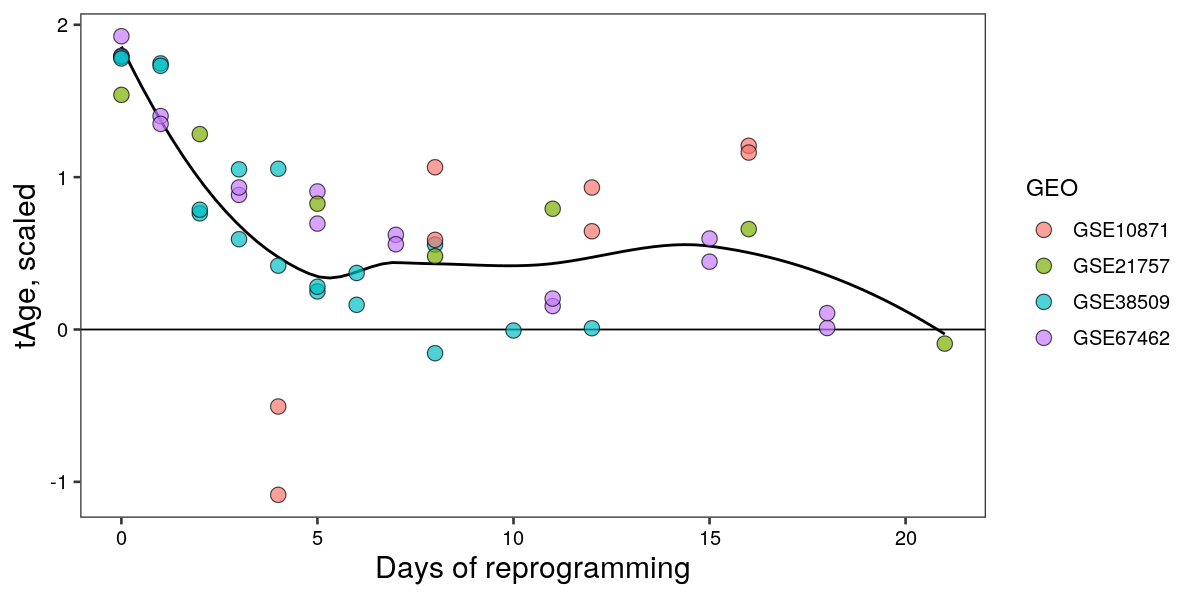

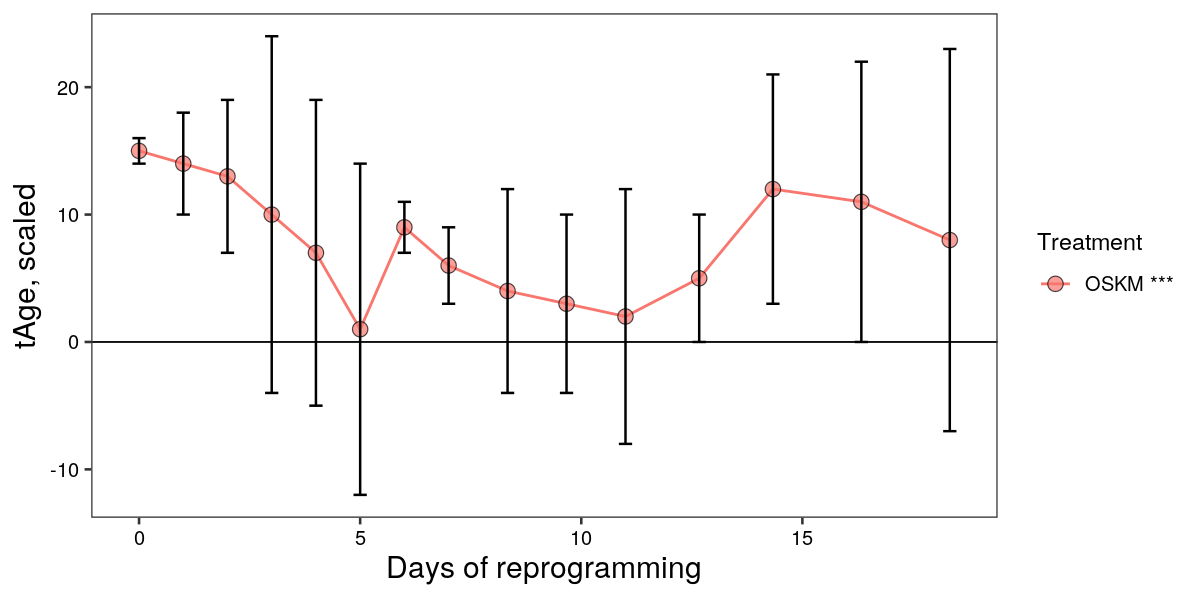

In [152]:
#Build moving average plots (with the step of +-1)
options(repr.plot.width = 10, repr.plot.height = 5)
mouse_ma_output <- visualize_plots(oskm_predictions,
                                   "tAge_model_mouse_norm","scaled",single_plot = T,
                                   separate_by_geo = F,scaling = T,moving_average = T,
                                   point_size = 4,point_alpha=0.7,axis_size=10,
                                   title_size=12,
                                   label_size=12,legend_size=12,
                                   line_width=0.8,legend_within = F,step=1,
                                   file_name="OSKM.tAge_model_mouse_norm.Scaled_MA.pdf")
mouse_ma_output$Species <- "Mouse"


In [153]:

#4. Save output table
bad_models <- colnames(mouse_predictions)[grepl("tAge",colnames(mouse_predictions))]
chosen_models <- c("tAge_model_mouse_norm")
bad_models <- setdiff(bad_models,chosen_models)
mouse_predictions <- mouse_predictions[,!(colnames(mouse_predictions) %in% bad_models)]

for (temp_model in chosen_models){
  for (temp_dataset in levels(factor(mouse_predictions$Dataset))){
    mouse_predictions[mouse_predictions$Dataset==temp_dataset,paste0(temp_model,".Scaled")] <- scale(mouse_predictions[mouse_predictions$Dataset==temp_dataset,temp_model],center = F,scale = T)
  }  
}
colnames(mouse_predictions) <- gsub("_norm","",colnames(mouse_predictions))
colnames(mouse_predictions) <- gsub("_model","",colnames(mouse_predictions))
head(mouse_predictions)
write.csv(mouse_predictions,"tmp/Mouse_predictions_clock.csv",row.names = F)

,ID,GSE,Treatment,GSM,Time,BatchTreatment,Dataset,AgeNorm,GEO,tAge_mouse,tAge_mouse.Scaled
,<fct>,<fct>,<chr>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<fct>,<dbl>,"<dbl[,1]>"
1,GSE67462$OSKM$$GSM1647454,GSE67462,OSKM,GSM1647454,0,OSKM,GSE67462.OSKM,0.14929771,GSE67462,0.14929771,1.9249517
2,GSE67462$OSKM$$GSM1647455,GSE67462,OSKM,GSM1647455,0,OSKM,GSE67462.OSKM,0.13932956,GSE67462,0.13932956,1.7964286
3,GSE67462$OSKM$$GSM1647456,GSE67462,OSKM,GSM1647456,1,OSKM,GSE67462.OSKM,0.10865417,GSE67462,0.10865417,1.4009191
4,GSE67462$OSKM$$GSM1647457,GSE67462,OSKM,GSM1647457,1,OSKM,GSE67462.OSKM,0.10466631,GSE67462,0.10466631,1.3495022
5,GSE67462$OSKM$$GSM1647458,GSE67462,OSKM,GSM1647458,3,OSKM,GSE67462.OSKM,0.06851137,GSE67462,0.06851137,0.8833429
6,GSE67462$OSKM$$GSM1647459,GSE67462,OSKM,GSM1647459,3,OSKM,GSE67462.OSKM,0.07229921,GSE67462,0.07229921,0.9321810


In [160]:
#II. Human
#1. Download and preprocess tAge predictions
human_predictions <- clockh

human_predictions$tAge <- human_predictions$AgeNorm
human_predictions$tAge_model_human_norm <-human_predictions$tAge

human_predictions$Dataset <- paste0(human_predictions$GEO,".",human_predictions$Treatment)
output_human <- fill_tAge_pvalues(human_predictions)
nrow(output_human)
#12 datasets in total
FDR_thresh <- 0.05
output_human[,grepl("tAge",colnames(output_human))] <- apply(output_human[,grepl("tAge",colnames(output_human))],2,function(x){p.adjust(x,"BH")})
apply(output_human[,grepl("tAge",colnames(output_human))],2,
      function(x){sum(x<FDR_thresh)})
#Norm mouse and human models are the best:)


[1] 12

tAge_mouse            tAge_human     tAge_human.Scaled 
                   11                     8                     8 
    tAge_mouse.Scaled                  tAge tAge_model_human_norm 
                   11                     8                     8

 [1] 1.5973633 1.4987757 1.5222724 1.3533756 1.5720002 1.8515796 1.2376375
 [8] 0.8443242 1.3932111 0.7799506 0.7668657 0.7587156 0.8502016 0.3062819
[15] 0.3209535 1.6314858 1.7392718 1.4325854 1.1898238 1.4639488 1.4715582
[22] 1.3436514 1.0614444 1.0947283 1.4004120
 [1]  0  3  7 11 15 20 28 35 42 49


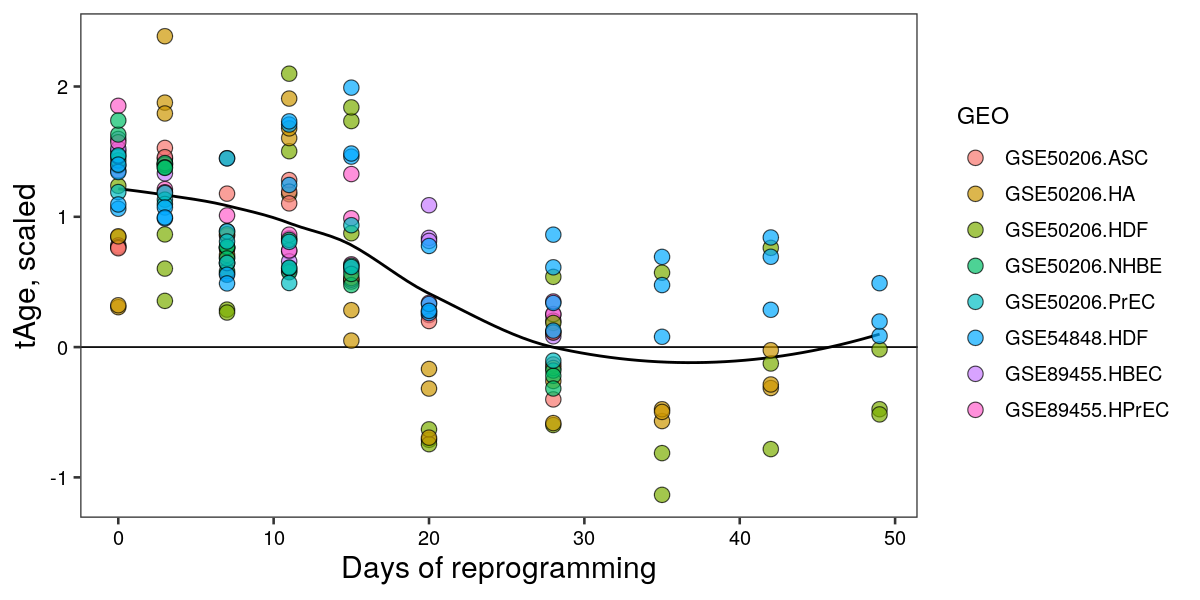

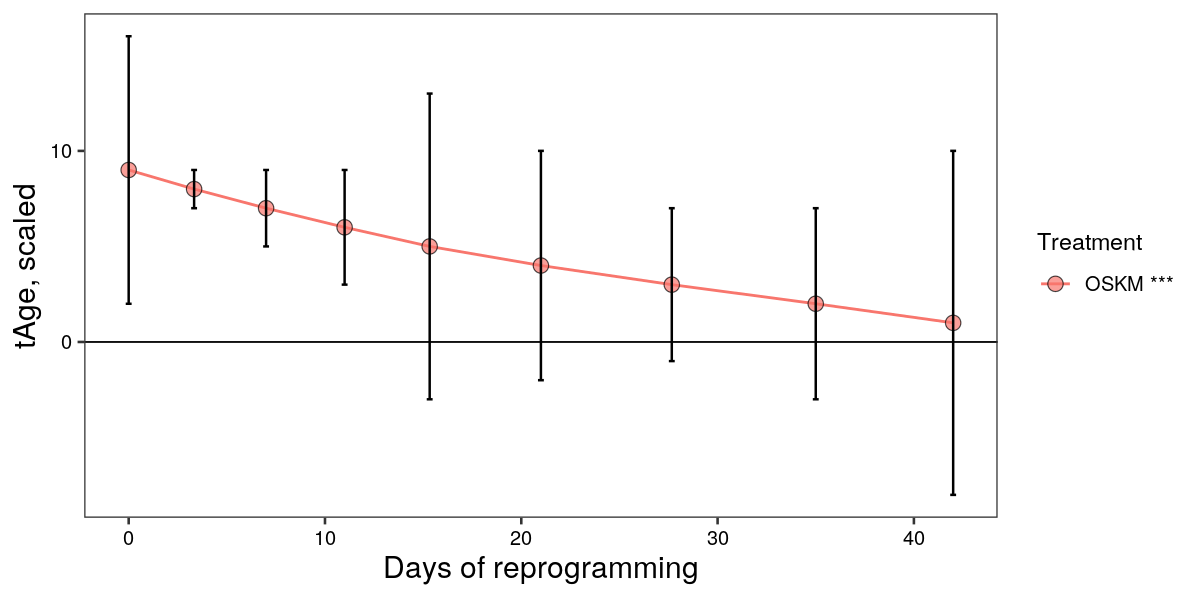

In [161]:

#Specify datasets with significant rejuvenation effect
significant_human_model <- output_human[output_human$tAge_model_human_norm<FDR_thresh,]$Dataset
#significant_mouse_model <- output_human[output_human$tAge_model_mouse_norm<FDR_thresh,]$Dataset
#significant_mouse_model <- setdiff(significant_mouse_model,"GSE28688.OSKM_HFF")


#Build moving average plots (with the step of +-1)
temp_human <- human_predictions
temp_human$Treatment <- gsub("OSKM_","",temp_human$Treatment)
temp_human$GEO <- paste(temp_human$GEO,temp_human$Treatment,sep=".")
temp_human$Treatment <- "OSKM"
#Human clock
human_ma_output <- visualize_plots(temp_human[temp_human$Dataset %in% significant_human_model,],
                                   "tAge_model_human_norm","scaled",single_plot = T,
                                   separate_by_geo = F,scaling = T,
                                   point_size = 4,point_alpha=0.7,axis_size=10,
                                   title_size=12,moving_average = T,
                                   label_size=12,legend_size=12,
                                   line_width=0.8,legend_within = F,step=1,
                                   file_name="tmp/OSKM.tAge_model_human_norm.Scaled_MA.pdf")
human_ma_output$Species <- "Human"


In [162]:

#4. Save output table
bad_models <- colnames(human_predictions)[grepl("tAge",colnames(human_predictions))]
chosen_models <- c("tAge_model_human_norm")
bad_models <- setdiff(bad_models,chosen_models)
human_predictions <- human_predictions[,!(colnames(human_predictions) %in% bad_models)]

for (temp_model in chosen_models){
  for (temp_dataset in levels(factor(human_predictions$Dataset))){
    human_predictions[human_predictions$Dataset==temp_dataset,paste0(temp_model,".Scaled")] <- scale(human_predictions[human_predictions$Dataset==temp_dataset,temp_model],center = F,scale = T)
  }  
}
colnames(human_predictions) <- gsub("_norm","",colnames(human_predictions))
colnames(human_predictions) <- gsub("_model","",colnames(human_predictions))
head(human_predictions)
write.csv(human_predictions,"tmp/Human_predictions_clock.csv",row.names = F)

,ID,Dataset,GEO,Treatment,Time,AgeNorm,Tissue,tAge_human,tAge_human.Scaled
,<fct>,<chr>,<fct>,<fct>,<int>,<dbl>,<fct>,<dbl>,"<dbl[,1]>"
1,GSE89455.OSKM.HDF.GSM2372432,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,0,0.13425485,DF,0.13425485,0.8800374
2,GSE89455.OSKM.HDF.GSM2372433,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,0,0.12798792,DF,0.12798792,0.8389578
3,GSE89455.OSKM.HDF.GSM2372434,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,0,0.17139022,DF,0.17139022,1.1234589
4,GSE89455.OSKM.HDF.GSM2372435,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,3,0.11609636,DF,0.11609636,0.7610089
5,GSE89455.OSKM.HDF.GSM2372436,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,3,0.09225089,DF,0.09225089,0.6047024
6,GSE89455.OSKM.HDF.GSM2372437,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,3,0.10495103,DF,0.10495103,0.6879515


[1] 15
[1] 9
[1] 15
[1] 9


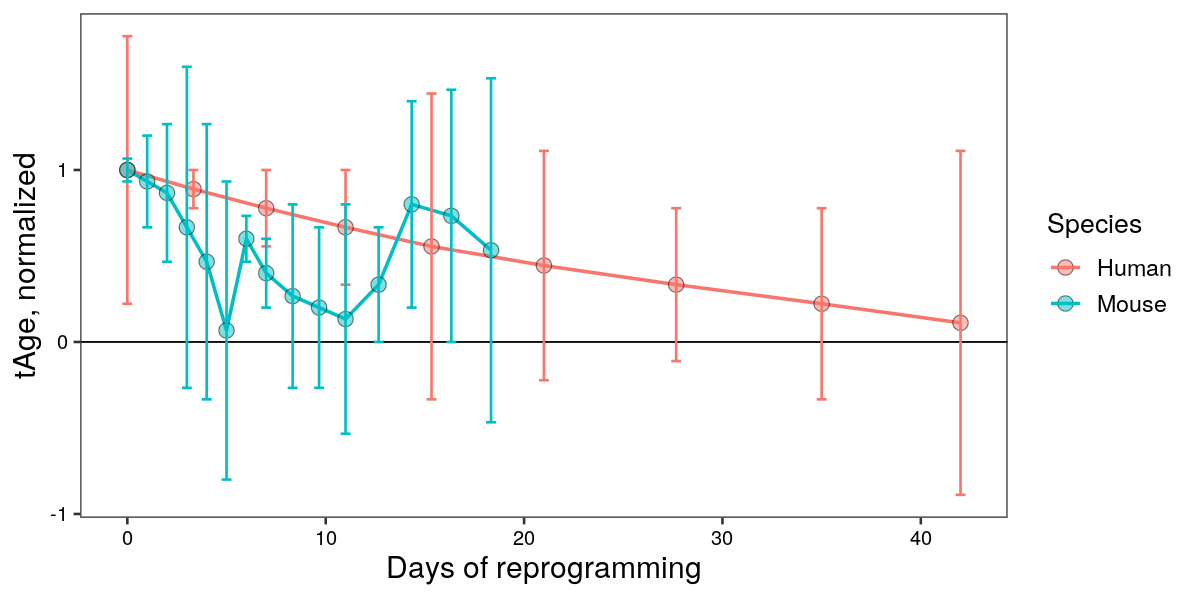

In [165]:

#5. Visualize human and mouse plots together
ma_outputs <- rbind(human_ma_output,mouse_ma_output)
for (i in c("SE","Mean")){
  for (j in c("Mouse","Human")){
    print(ma_outputs[ma_outputs$Species==j & ma_outputs$Time==0,]$Mean)
    ma_outputs[ma_outputs$Species==j,i] <- ma_outputs[ma_outputs$Species==j,i]/ma_outputs[ma_outputs$Species==j & ma_outputs$Time==0,]$Mean
  }
}
limits <- aes(ymin=Mean-SE,ymax=Mean+SE)
t <- ggplot(ma_outputs,aes(x=Time,y=Mean,fill=Species,color=Species))+
  labs(x="Days of reprogramming",y="tAge, normalized")+
  theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
  geom_line(aes(color=Species),lwd=1)+
  geom_point(colour="black",size=4,shape=21,alpha=0.5)+
  geom_errorbar(limits,width=0.5,size=0.75)+
  theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
        axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
        axis.text.y = element_text(size=12,color="black"),
        axis.title=element_text(size=18),
        legend.title=element_text(size=14+2,color="black"),
        legend.text=element_text(size=14,color="black"),
        legend.key.size = unit(1.5, 'lines'),
        panel.grid = element_blank(),
        strip.background =element_rect(fill="white"),
        strip.text = element_text(size=12,face="bold"))
print(t)